In [1]:
import os
# Disable tokenizers parallelism
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install git+https://github.com/csebuetnlp/normalizer
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00
  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-_1pkg2bj
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-_1pkg2bj
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=c2cca515a1e6bef9a82a6c060b67261119abe855e5a3848155b02f8ae035673e
  Stored in directory: /tmp/pip-ephem-wheel-cache-f1k71hj0/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4

In [3]:
import pandas as pd
from collections import Counter
import re
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import evaluate
# from datasets import load_metric
import datasets
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from datasets import Dataset, DatasetDict
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import random
np.object = object
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding,BertModel,AutoTokenizer,AutoConfig,RobertaModel
from collections import defaultdict
import torch
import warnings
warnings.filterwarnings('ignore')
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AdamW
from sklearn.model_selection import KFold
from torch.cuda import amp

import gc
gc.enable()

In [4]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

In [5]:
df = pd.read_csv("/kaggle/input/bengali-pharmaceutical-reviews/LargePharmaVal.csv")

In [6]:
with pd.option_context('display.max_colwidth',0):
    display(df.sample(n=10))

,Reviews,category,Label,Length,Word Count
5416,এগুলো কোন ধরনের অবহেলা? সিরিঞ্জ এর সুচ ভাঙা 😠😠 আর ইনসুলিনের ডেট নাই। মিথ্যাবাদী প্রতারক সেলার চটকদার বিজ্ঞাপন দিয়ে আমাদের সাথে প্রতারণা করেছে। আমি খুব কষ্ট পেলাম।,medical_kits,1,163,27
9457,দাম অনুযায়ী মাস্ক ঠিক আছে। কানের ফিতা ঠিক আছে,medical_kits,3,46,9
2990,সবই ঠিকঠাক ছিল কিন্তু কিছুদিন পরেই নষ্ট হয়ে গেছে এখন আর পানি গরম হয়না। একমাসও ব্যবহার করতে পারি নাই। এত ফালতু যে কি আর বলবো।,medical_kits,1,126,25
6789,সব মিলিয়ে ডায়াপার মন্দ না। মোটামুটি ভালো,baby_items,3,42,7
7749,"কিছুদিন আগে এর দাম ছিল ১৫৫ টাকা কিন্তু চাহিদা বাড়তে বাড়তে দামও বেড়ে যাচ্ছে এটা উচিত নয়। আমি ব্যবহার করে ভালো রেজাল্ট পেয়েছি এটা ঠিক, \nতবে একটু দেখুন প্রাইজ কমানোর চেষ্টা করুন।",medical_kits,3,179,32
2008,নেবুলাইজার নিয়ে খুব হতাশ। একদম নিম্ন মানের আর দাম আর কোয়ালিটি মিলে না একদম,medical_kits,1,76,14
4065,"অনেক দিন মেয়াদ আছে,,তাও আবার এত কম দামে,,আমি অনেক খুশি,,সেলার খুব ভাল।\nপিকাপ পয়েন্ট এ নেয়া,তাই ডেলিভারি চার্জ লাগে নাই। \nসেলার ১০/১০🥰\nপণ্য ১০/১০০০০০০🥰🥰🥰\nডেলিভারি ১০/১০🥰\nদারাজ ১০/১০""",womens_item,5,184,28
8582,"এই স্লীপিং পিলটি খুব ব্যবহার করি, মনে হয় এই পিলটি আমার ঘুমের জন্য ভাল নয়।",medicines,2,75,15
6610,"প্যাকেট এমন খোলা অবস্থায় পেলাম.....একটি তেলের বোতল মিসিং, মেরে দিলো মনে হচ্ছে 😐",womens_item,2,79,13
8628,পাউডারের মিনিপাকগুলোর একটা প্যাক ফুটো হয়েছে। মনে হচ্ছিল ইচ্ছেকৃতভাবে ফুটো করে দেওয়া হয়েছে। আর বাটপারির দেশে ভালো লাগে না । অনলাইন সেলাররা একটা বাটপার আর বড় প্রতারক। মেডিসিন নিয়ে এমন কেউ করে?,medicines,1,190,32


In [7]:
df.shape

(9515, 5)

In [8]:
df.shape[0]*0.7

6660.5

In [9]:
df["Label"].value_counts()

Label
5    2238
1    2199
4    1989
2    1563
3    1526
Name: count, dtype: int64

In [10]:
df["Label"] = df["Label"] - 1
df["Label"].value_counts()

Label
4    2238
0    2199
3    1989
1    1563
2    1526
Name: count, dtype: int64

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(df))
    ax = sns.countplot(x=col,  data=df, order = df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

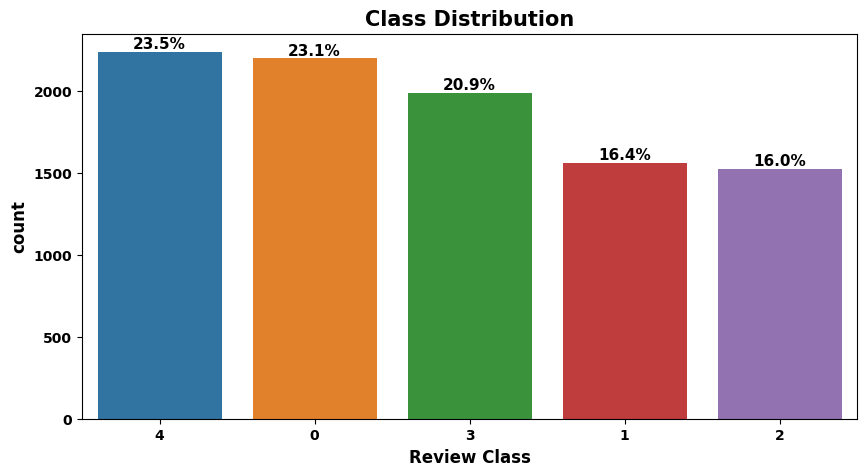

In [12]:
countplot(10,5,'Label',15,0,'Review Class','Class Distribution')

In [13]:
from sklearn.model_selection import train_test_split

# Step 1: Split the data into train and temp (test + validation) sets
X_train, X_test1, y_train, y_test1 = train_test_split(df['Reviews'], df['Label'], test_size=0.3, random_state=42, stratify=df['Label'])

# Step 2: Split the temp set into validation and test sets (10% validation, 20% test)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=2/3, random_state=42, stratify=y_test1)

In [14]:
X_train.shape

(6660,)

In [15]:
train_df = pd.DataFrame()
train_df['text'] = X_train.values
train_df['label'] = y_train.values


In [16]:
val_df = pd.DataFrame()
val_df['text'] = X_val.values
val_df['label'] = y_val.values

In [17]:
test_df = pd.DataFrame()
test_df['text'] = X_test.values
test_df['label'] = y_test.values

In [18]:
train_df.shape

(6660, 2)

In [19]:
train_df.head()

,text,label
0,১০০% অরিজিনাল প্রোডাক্ট! খুব উন্নত মানের প্রোড...,4
1,আলহামদুলিল্লাহ অনেক অনেক ভালো লেগেছে 😍। সুন্দর...,4
2,প্রথম প্রথম ব্যবহার করে খুব ভালো ফল পেয়েছিলাম ...,2
3,অসংখ্য ধন্যবাদ সেলারকে। তিনি কারেন্ট ডেটের এবং...,4
4,৫০ টা মাস্কের অনেক গুলায় নাকে ফিট করার স্টিল ট...,2


In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1904 non-null   object
 1   label   1904 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 29.9+ KB


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train_df))
    ax = sns.countplot(x=col,  data=train_df, order = train_df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

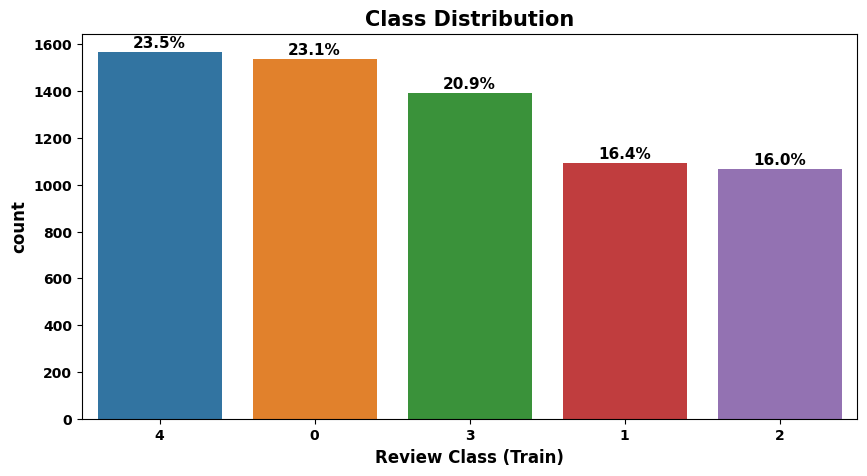

In [22]:
countplot(10,5,'label',15,0,'Review Class (Train)','Class Distribution')

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(val_df))
    ax = sns.countplot(x=col,  data=val_df, order = val_df[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

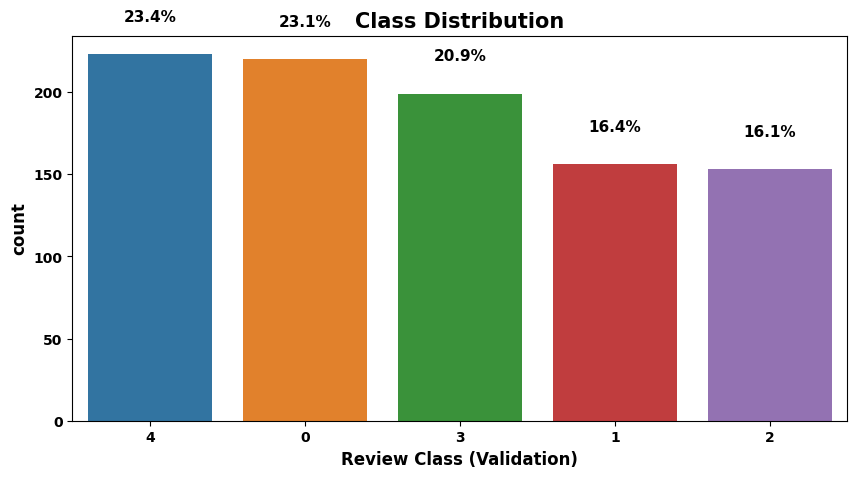

In [24]:
countplot(10,5,'label',15,0,'Review Class (Validation)','Class Distribution')

In [25]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [26]:
class Config:
    num_classes = 5
    path =  "ai4bharat/indic-bert"
    num_epochs = 10
    batch_size = 32
    SEED = 42
    learning_rate = 1e-5
    device = "cuda" if torch.cuda.is_available() else "cpu"

config = Config()

In [27]:
tokenizer = AutoTokenizer.from_pretrained(config.path)

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

<Axes: ylabel='Count'>

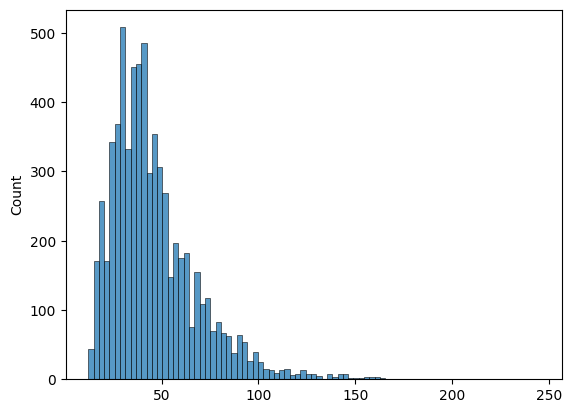

In [28]:
token_counts = []
for _, row in train_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

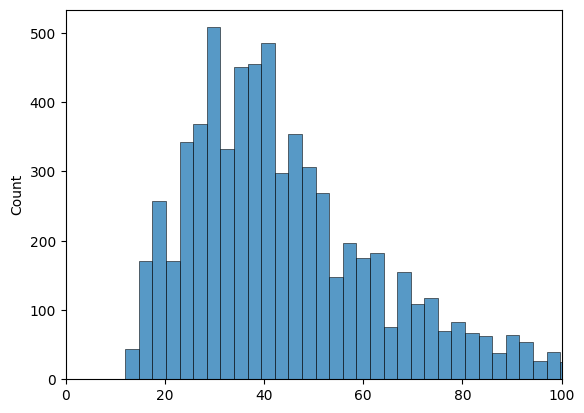

In [29]:
sns.histplot(token_counts)
plt.xlim([0, 100]);

<Axes: ylabel='Count'>

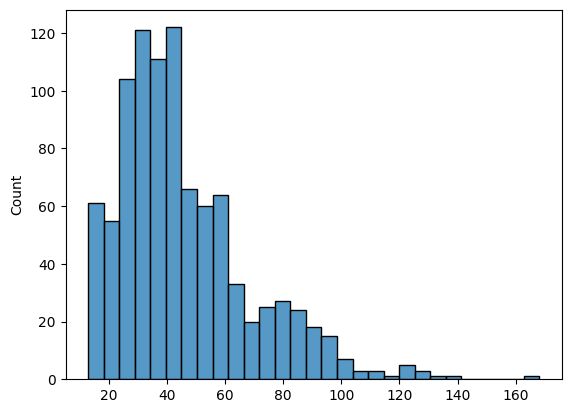

In [30]:
token_counts = []
for _, row in val_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

In [31]:
max(token_counts)

168

<Axes: ylabel='Count'>

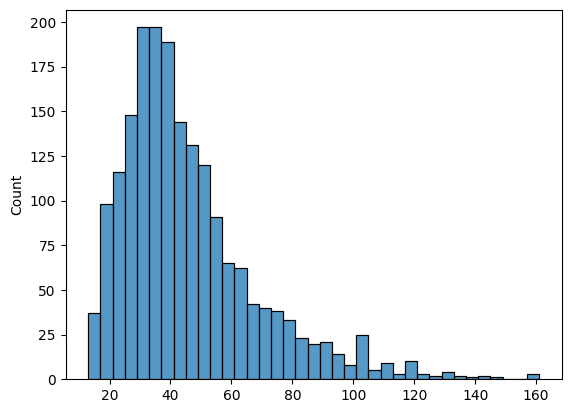

In [32]:
token_counts = []
for _, row in test_df.iterrows():
    token_count = len(tokenizer.encode(
    row["text"],
    max_length=512,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)

In [33]:
max(token_counts)

161

In [34]:
max_token_length = 120
def tokenize_function(example):
    return tokenizer(example["text"], padding = True, truncation=True, max_length=max_token_length)

# mapping dataset (actually texts) into tokenized values of pretrained model (provided in path)
tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True)
tokenized_val_datasets = val_dataset.map(tokenize_function, batched=True)
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6660 [00:00<?, ? examples/s]

Map:   0%|          | 0/951 [00:00<?, ? examples/s]

Map:   0%|          | 0/1904 [00:00<?, ? examples/s]

In [35]:
tokenized_train_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6660
})

In [36]:
tokenized_val_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 951
})

In [37]:
tokenized_test_datasets

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1904
})

In [38]:
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_val_datasets = tokenized_val_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_test_datasets = tokenized_test_datasets.remove_columns(['text', 'token_type_ids'])
tokenized_train_datasets.set_format("torch")
tokenized_val_datasets.set_format("torch")
tokenized_test_datasets.set_format("torch")

In [39]:
tokenized_test_datasets.column_names

['label', 'input_ids', 'attention_mask']

In [40]:
# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.bert = BertModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.45)
#         self.out = nn.Linear(768, config.num_classes)

#     def forward(self, input_ids, attention_mask):
#         output = self.bert(
#             input_ids = input_ids,
#             attention_mask = attention_mask
#         )

#         x = self.drop(output[1])

#         return self.out(x)

# '''XLM-R Model'''
# from transformers import XLNetModel, XLNetTokenizer

# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.xlnet = XLNetModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.30)
#         self.out = nn.Linear(768, config.num_classes)  

#     def forward(self, input_ids, attention_mask):
#         # XLNet returns two outputs: the last hidden state and the pooled output (similar to BERT)
#         output = self.xlnet(
#             input_ids = input_ids,
#             attention_mask = attention_mask
#         )

#         # Take the first token's representation
#         cls_output = output.last_hidden_state[:, 0, :]  
#         x = self.drop(cls_output)

#         return self.out(x)


# '''ALBert Model'''
# from transformers import AlbertModel


# class ClassifierModel(nn.Module):

#     def __init__(self):
#         super(ClassifierModel, self).__init__()
#         self.albert = AlbertModel.from_pretrained(config.path)
#         self.drop = nn.Dropout(p=0.45)
#         self.out = nn.Linear(768, config.num_classes) 

#     def forward(self, input_ids, attention_mask):
#         output = self.albert(
#             input_ids=input_ids,
#             attention_mask=attention_mask
#         )

#         pooled_output = output[1]  
#         x = self.drop(pooled_output)

#         return self.out(x)


'''Indic-BERT'''

from transformers import AutoModel

class ClassifierModel(nn.Module):
    def __init__(self, config):
        super(ClassifierModel, self).__init__()
        self.bert = AutoModel.from_pretrained(config.path)  # Changed to AutoModel
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(768, config.num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled_output = outputs.pooler_output  # Using pooler_output safely
        x = self.dropout(pooled_output)

        return self.fc(x)


In [41]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score


class Engine:
    def __init__(self, model, optimizer,scheduler = None):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        
    @staticmethod
    def loss_fn(target, pred):
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(pred,target)
        return loss
    
    @staticmethod
    def compute_metrics(labels, pred):
        y_true = labels.cpu().numpy()
        pred = pred.cpu().numpy()
        y_pred = np.argmax(pred, axis = -1)
        f1 = f1_score(y_true, y_pred, average='macro')
        return f1
        
    def train(self, train_dataloader,scaler,num_training_steps):
        self.model.train()
        total_training_loss = 0.0
        DEVICE = config.device
        progress_bar = tqdm(range(num_training_steps))
        for data in train_dataloader:
            input_ids = data["input_ids"].to(DEVICE)
            attention_mask = data["attention_mask"].to(DEVICE)            
            target = data["labels"].to(DEVICE)
            self.optimizer.zero_grad()
            
            with amp.autocast():
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                
            total_training_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()
            if self.scheduler:
                self.scheduler.step()
            progress_bar.update(1)
                
        return total_training_loss / len(train_dataloader)
    
    def evaluate(self,eval_dataloader):
        self.model.eval()
        DEVICE = config.device
        val_loss = 0
        score = 0.0
        with torch.no_grad():
            for data in tqdm(eval_dataloader):
                input_ids = data["input_ids"].to(DEVICE)
                attention_mask = data["attention_mask"].to(DEVICE)            
                target = data["labels"].to(DEVICE)
                
                pred = self.model(input_ids, attention_mask)
                loss = self.loss_fn(target,pred)
                val_loss += loss.item()
                batch_score = self.compute_metrics(target,pred)
                score+= batch_score
             
            score = score / len(eval_dataloader)
            val_loss = val_loss / len(eval_dataloader)
        
        return score, val_loss

In [42]:
from transformers import get_scheduler

def run_training(save_model = False):

    train_loader = DataLoader(tokenized_train_datasets, batch_size = config.batch_size,
                              collate_fn=data_collator, shuffle =True, num_workers=2)    
    val_loader = DataLoader(tokenized_val_datasets, batch_size = config.batch_size,
                            drop_last=False,collate_fn=data_collator, shuffle=False, num_workers=2)   
    set_random_seed(config.SEED)
    model = ClassifierModel(config)
    model.to(config.device)
    
#     optimizer = create_optimizer(model)  
    optimizer = torch.optim.AdamW(model.parameters(), lr = config.learning_rate, weight_decay=0.01)
    num_training_steps = config.num_epochs * len(train_loader)
    
    scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
    )
    eng = Engine(model, optimizer, scheduler)
    scaler = amp.GradScaler()
    early_stopping_iter = 5
    early_stopping_counter = 0
    best_score = 0.0
    for epoch in range(config.num_epochs):
        train_loss = eng.train(train_loader,scaler,num_training_steps)
        val_score,val_loss = eng.evaluate(val_loader)
        
        print(f" Epoch: {epoch + 1} | Training_loss: {round(train_loss,5)} | Val_loss: {round(val_loss,5)} | Val_Score: {round(val_score,5)}")
        
        if val_score > best_score:
            best_score = val_score
            
            if save_model:
                torch.save(model.state_dict(),f"mbert_model.bin")
        else:
            early_stopping_counter +=1
            
        if early_stopping_counter > early_stopping_iter:
            break
            
    del model
    gc.collect()
            
    return best_score

In [43]:
score = run_training(save_model = True)
print(f"Best Score: {score}")

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 1 | Training_loss: 1.40419 | Val_loss: 1.15983 | Val_Score: 0.46549


  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 2 | Training_loss: 0.99077 | Val_loss: 0.87794 | Val_Score: 0.58192


  0%|          | 0/2090 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3deea88160><function _MultiProcessingDataLoaderIter.__del__ at 0x7d3deea88160>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 3 | Training_loss: 0.73367 | Val_loss: 0.72788 | Val_Score: 0.61083


  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 4 | Training_loss: 0.51101 | Val_loss: 0.57291 | Val_Score: 0.74807


  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 5 | Training_loss: 0.39675 | Val_loss: 0.51052 | Val_Score: 0.77982


  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 6 | Training_loss: 0.31636 | Val_loss: 0.45506 | Val_Score: 0.80233


  0%|          | 0/2090 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d3deea88160>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d3deea88160>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 7 | Training_loss: 0.24747 | Val_loss: 0.44977 | Val_Score: 0.8003


  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 8 | Training_loss: 0.20002 | Val_loss: 0.45251 | Val_Score: 0.80871


  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 9 | Training_loss: 0.16426 | Val_loss: 0.45609 | Val_Score: 0.81112


  0%|          | 0/2090 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 Epoch: 10 | Training_loss: 0.14437 | Val_loss: 0.45434 | Val_Score: 0.81163
Best Score: 0.8116294497942094


In [44]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(
    tokenized_test_datasets, batch_size=32, collate_fn=data_collator
)

In [45]:
device = config.device

In [46]:
model = ClassifierModel(config)

In [47]:
model_path = f"/kaggle/working/mbert_model.bin"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [48]:
model.to(device)

ClassifierModel(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(200000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
 

In [49]:
model.eval()
prediction = []
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
        logits = outputs
        pred = torch.argmax(logits, dim=-1)
        prediction.extend(pred.cpu().numpy().tolist())

In [50]:
y_true = test_df.label.values
y_pred = prediction

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_true, y_pred))

[[417  11   9   1   2]
 [ 22 241  44   4   2]
 [  8  39 215  39   4]
 [  5   9  41 328  15]
 [  5   1   7  21 414]]


In [52]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Print the classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Calculate individual metrics for weighted and macro averages
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_f1 = f1_score(y_true, y_pred, average='macro')

weighted_precision = precision_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')

weighted_recall = recall_score(y_true, y_pred, average='weighted')
macro_recall = recall_score(y_true, y_pred, average='macro')

accuracy = accuracy_score(y_true, y_pred)

print("Model: Attention on BanglaBERT")

# Print metrics
print("Weighted F1 Score:", weighted_f1)
print("Macro F1 Score:", macro_f1)
print("Weighted Precision:", weighted_precision)
print("Macro Precision:", macro_precision)
print("Weighted Recall:", weighted_recall)
print("Macro Recall:", macro_recall)
print("Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       440
           1       0.80      0.77      0.79       313
           2       0.68      0.70      0.69       305
           3       0.83      0.82      0.83       398
           4       0.95      0.92      0.94       448

    accuracy                           0.85      1904
   macro avg       0.84      0.83      0.83      1904
weighted avg       0.85      0.85      0.85      1904

Confusion Matrix:
 [[417  11   9   1   2]
 [ 22 241  44   4   2]
 [  8  39 215  39   4]
 [  5   9  41 328  15]
 [  5   1   7  21 414]]
Model: Attention on BanglaBERT
Weighted F1 Score: 0.8483286773700055
Macro F1 Score: 0.8344273834683328
Weighted Precision: 0.8488476059964271
Macro Precision: 0.8350981730764202
Weighted Recall: 0.8482142857142857
Macro Recall: 0.8341682205009174
Accuracy: 0.8482142857142857


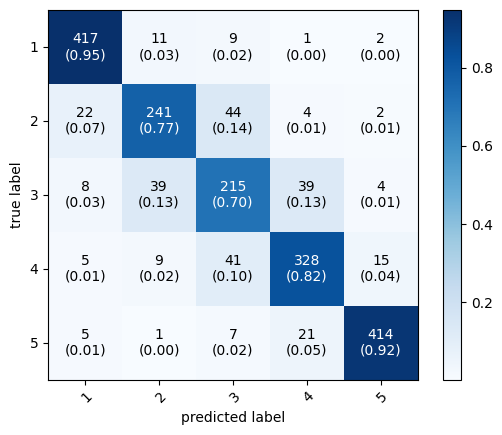

In [53]:
import torch
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix
y_pred = torch.tensor(y_pred)
y_true = torch.tensor(y_true)

cmat = ConfusionMatrix(task="multiclass", num_classes=5)
confusion_matrix = cmat(y_pred, y_true)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix.cpu().numpy(),
                                class_names=[1,2,3,4,5],
                                show_normed=True,
                                colorbar=True)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Show the plot
plt.show()